In [1]:
!pip install transformers

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 7.2/7.2 MB 98.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 236.8/236.8 kB 28.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 7.8/7.8 MB 107.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.3/1.3 MB 31.0 MB/s eta 0:00:00


In [2]:
import pandas as pd
import numpy as np
import torch
from torch.utils.data import Dataset, DataLoader
from transformers import DistilBertTokenizerFast, DistilBertForSequenceClassification, AdamW
from tqdm import tqdm
import matplotlib.pyplot as plt

In [3]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


##Pre-processing Data

In [4]:
#Biased data
data = pd.read_csv('/content/drive/MyDrive/BERT Models/Dataset/mergedData.csv')
data.drop_duplicates(subset = ['sentence'], inplace = True)
data.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 3141 entries, 0 to 3140
Data columns (total 2 columns):
 #   Column    Non-Null Count  Dtype 
---  ------    --------------  ----- 
 0   sentence  3141 non-null   object
 1   label     3141 non-null   int64 
dtypes: int64(1), object(1)
memory usage: 73.6+ KB


In [6]:
#Unbiased data
data2 = pd.read_csv('/content/drive/MyDrive/BERT Models/Dataset/unbiasedDataTrain.csv')
data2['sentence'].nunique()
lengths = data2['sentence'].str.len()
argmax = np.where(lengths == lengths.max())[0]
data2['sentence'].iloc[argmax]
# data2.sort_values('sentence',key=lambda x:x.str.len())

250    I just left the most cringeworthy voicemail to...
Name: sentence, dtype: object

In [5]:
lengths = data['sentence'].str.len()
argmax = np.where(lengths == lengths.max())[0]
data.iloc[argmax]

,sentence,label
2019,I think the culture (and laws) about it are di...,0


In [7]:
#custom dataset for supervised learning
class SlangDataset(Dataset):
  def __init__(self, filename, tokenizer):
    df = filename
    self.data = list(zip(df['sentence'], df['label']))
    self.tokenizer = tokenizer

  def __len__(self):
    return len(self.data)

  def __getitem__(self, idx):
    text, label = self.data[idx]
    inputs = self.tokenizer(text, padding='max_length', truncation=True, max_length=64, return_tensors='pt')
    inputs['input_ids'] = inputs['input_ids'].squeeze()
    inputs['attention_mask'] = inputs['attention_mask'].squeeze()
    return {
        'inputs': inputs,
        'label': torch.tensor(label, dtype=torch.long)
    }

model = DistilBertForSequenceClassification.from_pretrained('distilbert-base-uncased', num_labels=2) # 2 labels: Slang, No Slang
tokenizer = DistilBertTokenizerFast.from_pretrained('distilbert-base-uncased')
device = torch.device('cuda') if torch.cuda.is_available() else torch.device('cpu')
model.to(device)

dataset = data

#encoding the dataset for training
slang_dataset = SlangDataset(dataset, tokenizer)
dataloader = DataLoader(slang_dataset, batch_size=16, shuffle=True)

optimizer = AdamW(model.parameters(), lr=1e-5)

Some weights of the model checkpoint at distilbert-base-uncased were not used when initializing DistilBertForSequenceClassification: ['vocab_layer_norm.bias', 'vocab_transform.weight', 'vocab_layer_norm.weight', 'vocab_transform.bias', 'vocab_projector.bias']
- This IS expected if you are initializing DistilBertForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing DistilBertForSequenceClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of DistilBertForSequenceClassification were not initialized from the model checkpoint at distilbert-base-uncased and are newly initialized: ['pre_classifier.weight', 'classifier.weight', 'pre_classifier.bias', 'classifier.

/usr/local/lib/python3.10/dist-packages/transformers/optimization.py:411: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  warnings.warn(


In [8]:
n = 50
model.train()
loss_values = []
for epoch in tqdm(range(n), desc = 'Epochs'):
  epoch_loss = 0.0
  for i, batch in enumerate(tqdm(dataloader, desc = f'Batch (Epoch{epoch+1})')):
    input_ids = batch['inputs']['input_ids'].to(device)
    attention_mask = batch['inputs']['attention_mask'].to(device)
    labels = batch['label'].to(device)
    outputs = model(input_ids=input_ids, attention_mask=attention_mask, labels=labels)
    loss = outputs.loss
    epoch_loss += loss.item()
    loss.backward()
    optimizer.step()
    optimizer.zero_grad()
  epoch_loss = epoch_loss/len(dataloader)
  loss_values.append(epoch_loss)


Epochs: 100%|██████████| 50/50 [15:39<00:00, 18.80s/it]


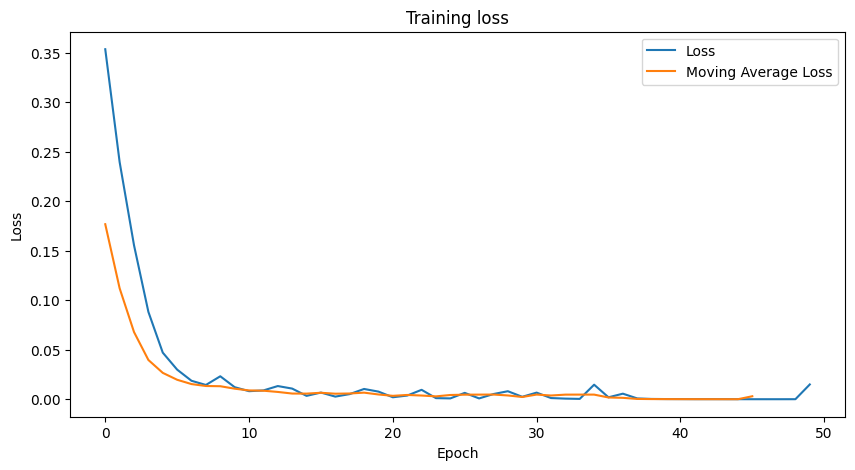

In [9]:
def moving_avg(a, n = 5):
  temp = np.cumsum(a, dtype = float)
  temp[n:] = temp[n:] - temp[:-n]
  return temp[n - 1:] / n

moving_avg_loss = moving_avg(loss_values, 5)

plt.figure(figsize=(10,5))
plt.title("Training loss")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.plot(loss_values, label='Loss')
plt.plot(range(len(moving_avg_loss)), moving_avg_loss, label='Moving Average Loss')
plt.legend()
plt.show()

In [10]:
model.save_pretrained('/content/drive/MyDrive/BERT Models/BERT Supervised Biased/model')
tokenizer.save_pretrained('/content/drive/MyDrive/BERT Models/BERT Supervised Biased/tokenizer')

('/content/drive/MyDrive/BERT Models/BERT Supervised Biased/tokenizer/tokenizer_config.json',
 '/content/drive/MyDrive/BERT Models/BERT Supervised Biased/tokenizer/special_tokens_map.json',
 '/content/drive/MyDrive/BERT Models/BERT Supervised Biased/tokenizer/vocab.txt',
 '/content/drive/MyDrive/BERT Models/BERT Supervised Biased/tokenizer/added_tokens.json',
 '/content/drive/MyDrive/BERT Models/BERT Supervised Biased/tokenizer/tokenizer.json')

In [11]:
model_dir = '/content/drive/MyDrive/BERT Models/BERT Supervised Biased/model'
tokenizer_dir = '/content/drive/MyDrive/BERT Models/BERT Supervised Biased/tokenizer'
model = DistilBertForSequenceClassification.from_pretrained(model_dir)
tokenizer = DistilBertTokenizerFast.from_pretrained(tokenizer_dir)

In [13]:
from sklearn.metrics import accuracy_score, f1_score, recall_score, precision_score, confusion_matrix, log_loss
from sklearn import metrics

testData = pd.read_csv('/content/drive/MyDrive/BERT Models/Dataset/mergedDataTest.csv', delimiter= ';')
texts = list(testData['sentence'])

inputs = tokenizer(texts, padding = "max_length", truncation = True, max_length = 64, return_tensors = 'pt')

with torch.no_grad():
  logits = model(**inputs).logits

probs = torch.nn.functional.softmax(logits, dim = -1)

predicted_labels = torch.argmax(probs, dim = -1)
confidence_scores = torch.max(probs, dim=-1)[0]

true_labels = list(testData['label'])

accuracy = accuracy_score(true_labels, predicted_labels.tolist())
f1 = f1_score(true_labels, predicted_labels.tolist())
recall = recall_score(true_labels, predicted_labels.tolist())
precision = precision_score(true_labels, predicted_labels.tolist())
conf_matrix = confusion_matrix(true_labels, predicted_labels.tolist())
matrix = metrics.ConfusionMatrixDisplay(confusion_matrix = conf_matrix, display_labels = ['Slang', 'No Slang'])
probs_np = probs.detach().cpu().numpy()
logloss = log_loss(true_labels, probs_np)

for i, text in enumerate(texts):
  prediction = 'Slang' if predicted_labels[i].item() == 1 else 'No Slang'
  is_correct = "Correct" if predicted_labels[i].item() == true_labels[i] else "Incorrect"
  print(f"Text: {text}")
  print(f"Predicted label: {'Slang' if predicted_labels[i].item() == 1 else 'No Slang'}")
  print(f"Prediction is: {is_correct}")
  print(f"Confidence score: {confidence_scores[i].item()}")
  print("\n")

Text: I'm just really stressing since I have student loans and I know that I'll have to start paying on them,  but I don't even have a "career" job.
Predicted label: No Slang
Prediction is: Correct
Confidence score: 0.9998247027397156


Text: Add laughably bad scripts and dated film making choices and you have the DCU.
Predicted label: No Slang
Prediction is: Correct
Confidence score: 0.9988839030265808


Text: In modern day i don't see the purpose of arranged marriages,  but then again I'm probably limited by the fact that I've lived in western communities all my life.
Predicted label: No Slang
Prediction is: Correct
Confidence score: 0.9998683929443359


Text: Try to focus on physical things around you, whether buildings or trees.
Predicted label: No Slang
Prediction is: Correct
Confidence score: 0.9998487234115601


Text: The one important thing is making sure people understand the difference between being gluten free and having celiac disease.
Predicted label: No Slang
Prediction i

Accuracy: 96.000%
F1-score: 33.333%
Recall: 25.000%
Precision: 50.000%
Log-loss: 0.30988027315291755


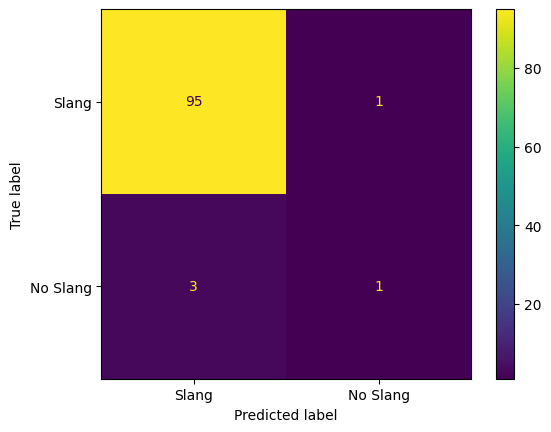

In [14]:
print(f"Accuracy: {accuracy*100:0.3f}%")
print(f"F1-score: {f1*100:0.3f}%")
print(f"Recall: {recall*100:0.3f}%")
print(f"Precision: {precision*100:0.3f}%")
matrix.plot()
print(f"Log-loss: {logloss}")
plt.show()

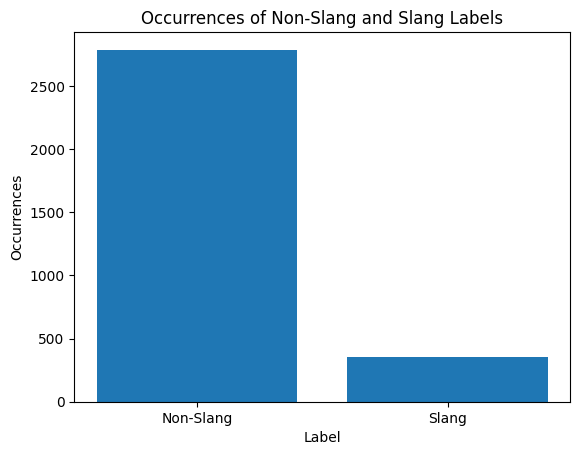

In [16]:
labels = data['label']

# Count occurrences of '0' and '1' labels
label_counts = labels.value_counts()

# Create a bar graph
plt.bar(label_counts.index, label_counts.values)
plt.xlabel('Label')
plt.ylabel('Occurrences')
plt.title('Occurrences of Non-Slang and Slang Labels')
plt.xticks(label_counts.index, ['Non-Slang', 'Slang'])
plt.show()
